# Simple NFT Wash Trade Detection

Author: @0xrwu (Twitter), richardwu (Github)

Data provided by: Tensor (https://www.tensor.trade/) <-- check it out (fastest NFT aggregator & marketplace on Solana!)

License: MIT

In [23]:
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Set, Optional

import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as pldates
import matplotlib.patches as mpatches

import seaborn as sns

import matplotlib as mpl

# 1. Hyperparameters

In [2]:
# Sale price / floor threshold for a tx to be a wash trade
WASH_MULT = 100
# Percentile of sale prices (across entire window, non-causal), where sale price / percentile(SALE_PRICE_PTILE) threshold for tx to be a "high price" trade
SALE_PRICE_PTILE = 0.25
# for the top 10% mints by rarity, sale price / floor threshold for tx to be an "high price" trade
HIGHPRICE_10PTILE_MULT = 50
# for the top 25% mints by rarity, sale price / floor threshold for tx to be an "high price" trade
HIGHPRICE_25PTILE_MULT = 20
# for all other mints (no rarity/bottom 75% by rarity), sale price / floor threshold for tx to be an "high price" trade
HIGHPRICE_REST_MULT = 2

# 2. Helper fns

## Core logic for cycle detection

In [3]:
def dfs(
    # cur (wallet, mint)
    cur: Tuple[str, str],
    # visited (wallet, mint)
    visited: Set[Tuple[str, str]],
    # set of (wallet, mint) in the current path
    stack: Set[Tuple[str, str]], 
    # seller -> mint -> buyer -> set sigs
    graph: Dict[str, Dict[str, Dict[str, Set[str]]]],
    # set of sigs involved in cycles
    wash_sigs: Set[str]
):
    cur_wallet, cur_mint = cur
    visited.add(cur)
    stack.add(cur)
    
    if not graph.get(cur_wallet, {}).get(cur_mint, None):
        return False
        
    has_cycle = False
    for neigh, sigs in graph[cur_wallet][cur_mint].items():
        nxt = (neigh, cur_mint)
        
        # If a mint has been sold more than once for the same buyer/seller, probably a wash trade
        if len(sigs) > 1:
            wash_sigs.update(sigs)
            has_cycle = True
        
        if nxt not in visited:
            if dfs(nxt, visited, stack, graph, wash_sigs):
                wash_sigs.update(sigs)
                has_cycle = True
        elif nxt in stack:
            wash_sigs.update(sigs)
            has_cycle = True
    
    stack.remove(cur)
    return has_cycle

## Run cycle detection + mark what's wash + what's excluded (high sale price vs floor)

In [4]:
def calc_wash_sigs(df_data):
    graph = {}
    for _, row in df_data.iterrows():
        graph[row['sellerId']] = graph.get(row['sellerId'], {})
        graph[row['sellerId']][row['mintOnchainId']] = graph[row['sellerId']].get(row['mintOnchainId'], {})
        graph[row['sellerId']][row['mintOnchainId']][row['buyerId']] = graph[row['sellerId']][row['mintOnchainId']].get(row['buyerId'], set())
        graph[row['sellerId']][row['mintOnchainId']][row['buyerId']].add(row['txId'])

    visited = set()
    stack = set()
    wash_sigs = set()

    for seller, dct in graph.items():
        for mint, _ in dct.items():
            if (seller, mint) in visited:
                continue
            dfs((seller, mint), visited, stack, graph, wash_sigs)
    return wash_sigs

In [5]:
def calc_wash_highprice(df_data, wash_sigs: List[str]):
    df_out = df_data.copy()
    df_out['date'] = pd.to_datetime(df_out.txAtUnix, unit='s')

    df_out['rank'] = df_out.rarity / df_out.numMints
    df_out.loc[df_out.rarity.isnull(), 'rank'] = None
    
    df_out['wash_sig'] = df_out.txId.isin(wash_sigs)
    df_out['wash_floor'] = df_out.grossAmount > WASH_MULT * df_out.floorPrice
    df_out['wash'] = df_out['wash_sig'] | df_out['wash_floor']
    
    df_out['highprice_nofp'] = df_out.floorPrice.isnull()
    df_out['highprice_10ptile'] = (df_out['rank'] <= 0.1) & (df_out.grossAmount > HIGHPRICE_10PTILE_MULT * df_out.floorPrice)
    df_out['highprice_25ptile'] = (df_out['rank'] > 0.1) & (df_out['rank'] <= 0.25) & (df_out.grossAmount > HIGHPRICE_25PTILE_MULT * df_out.floorPrice)
    df_out['highprice_rest'] = (df_out['rank'].isnull() | (df_out['rank'] > 0.25)) & (df_out.grossAmount > HIGHPRICE_REST_MULT * df_out.floorPrice)
    
    slug_sale_ptile = df_out.groupby('slugDisplay')['grossAmount'].quantile(SALE_PRICE_PTILE).to_dict()
    df_out['highprice_sale_ptile'] = np.array([
        row.grossAmount > WASH_MULT * slug_sale_ptile[row.slugDisplay] for row in df_out.itertuples()])
    
    df_out['highprice'] = (
        df_out['highprice_nofp'] 
        | df_out['highprice_10ptile'] 
        | df_out['highprice_25ptile'] 
        | df_out['highprice_rest']
        | df_out['highprice_sale_ptile']
    )
    
    return df_out

## Plotting fn

In [6]:
NORMAL_COL = '#648FFF'
HP_COL = '#DC267F'
WASH_COL = '#FFB000'

In [7]:
def plot_source(
    df_data, 
    source: Optional[str], 
    ax,
    only_normal=False
):
    df_filtered = df_data.copy(deep=False)
    
    if source:
        df_filtered = df_filtered[df_filtered['source'] == source] 

    df_temp = df_filtered[(~df_filtered['highprice']) & (~df_filtered['wash'])]
    df_normal = df_temp.groupby(
        df_temp.date.dt.date)[['grossAmount']].sum().sort_index().reset_index()
    df_normal['type'] = 'normal' 
    
    df_temp = df_filtered[df_filtered['highprice'] & (~df_filtered['wash'])]
    df_exclude = df_temp.groupby(df_temp.date.dt.date)[['grossAmount']].sum().sort_index().reset_index()
    df_exclude['type'] = 'high price' 
    
    df_temp = df_filtered[df_filtered['wash']]
    df_wash = df_temp.groupby(df_temp.date.dt.date)[['grossAmount']].sum().sort_index().reset_index()
    df_wash['type'] = 'wash'
    
    df_plot = pd.concat([df_normal, df_exclude, df_wash]).pivot(index='date', values='grossAmount', columns='type')[[
        'wash', 'high price', 'normal'
    ]]
    
    if only_normal:
        df_plot = df_plot[['normal']]
        df_plot.plot(kind='bar', stacked=True, ax=ax,
             color=[NORMAL_COL],
             fontsize=20, width=1)
    else:
        df_plot.plot(kind='bar', stacked=True, ax=ax,
                     color=[WASH_COL, HP_COL, NORMAL_COL],
                     fontsize=20, width=1)
    
    ax.legend(fontsize=20)
    
    ax.set_ylabel('Volume (SOL)', fontsize=20)
    ax.set_xlabel('Date', fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.xaxis.set_major_locator(pldates.AutoDateLocator())

# 3. Data loading

Required columns:
- txId: signature
- txAtUnix: unix seconds of tx
- buyerId
- sellerId
- source
- mintOnchainId
- grossAmount
- slugDisplay: to identify collection
- floorPrice
- rarity: NFT's rarity rank in its collection
- numMints: total # NFTs in collection

In [8]:
df_tswap = pd.read_csv('../data/20230301_tswap_txs_w_rarity.csv')

In [9]:
df_hswap = pd.read_csv('../data/20230301_hswap_txs_w_rarity.csv')

**Instructions**: Download from GenesysGo's Shadow Drive link: https://download.sdrive.app/file/b00d1afaee62e8c9acf171d5d20e6ce5

Unzip and place in `data/` folder

In [10]:
df_mkt = pd.read_csv('../data/20230301_marketplace_txs_w_rarity.csv')

In [21]:
df_mkt.to_csv('../data/20230301_marketplace_txs_w_rarity.csv', index=False)

In [11]:
df_tswap.shape

(46484, 13)

In [12]:
df_hswap.shape

(182399, 13)

In [13]:
df_mkt.shape

(8477259, 13)

In [14]:
df_all = pd.concat([df_tswap, df_hswap, df_mkt])

In [15]:
df_all = df_all[
    # Filter out non-verified collections
    df_all['slugDisplay'].notnull() &
    df_all['buyerId'].notnull() & df_all['sellerId'].notnull() & df_all['mintOnchainId'].notnull()]

In [16]:
df_all.shape

(8490636, 13)

In [17]:
df_all.isnull().sum(axis=0)

txId                  0
txAtUnix              0
txType                0
source                0
buyerId               0
sellerId              0
mintOnchainId         0
grossAmount           0
slug                  0
slugDisplay           0
floorPrice       103269
rarity           223143
numMints              0
dtype: int64

# 4. Run algo + create summary DFs

### This takes some time 👀

In [18]:
all_wash_sigs = calc_wash_sigs(df_all)

In [19]:
len(all_wash_sigs)

812086

In [24]:
df_all_out = calc_wash_highprice(df_all, all_wash_sigs)

# 5. Plot stuff

In [27]:
mpl.style.use('fivethirtyeight')

## Overall view

Text(147, 250000, 'Tensor whale $7.5M wash trade\n(2023-02-24)')

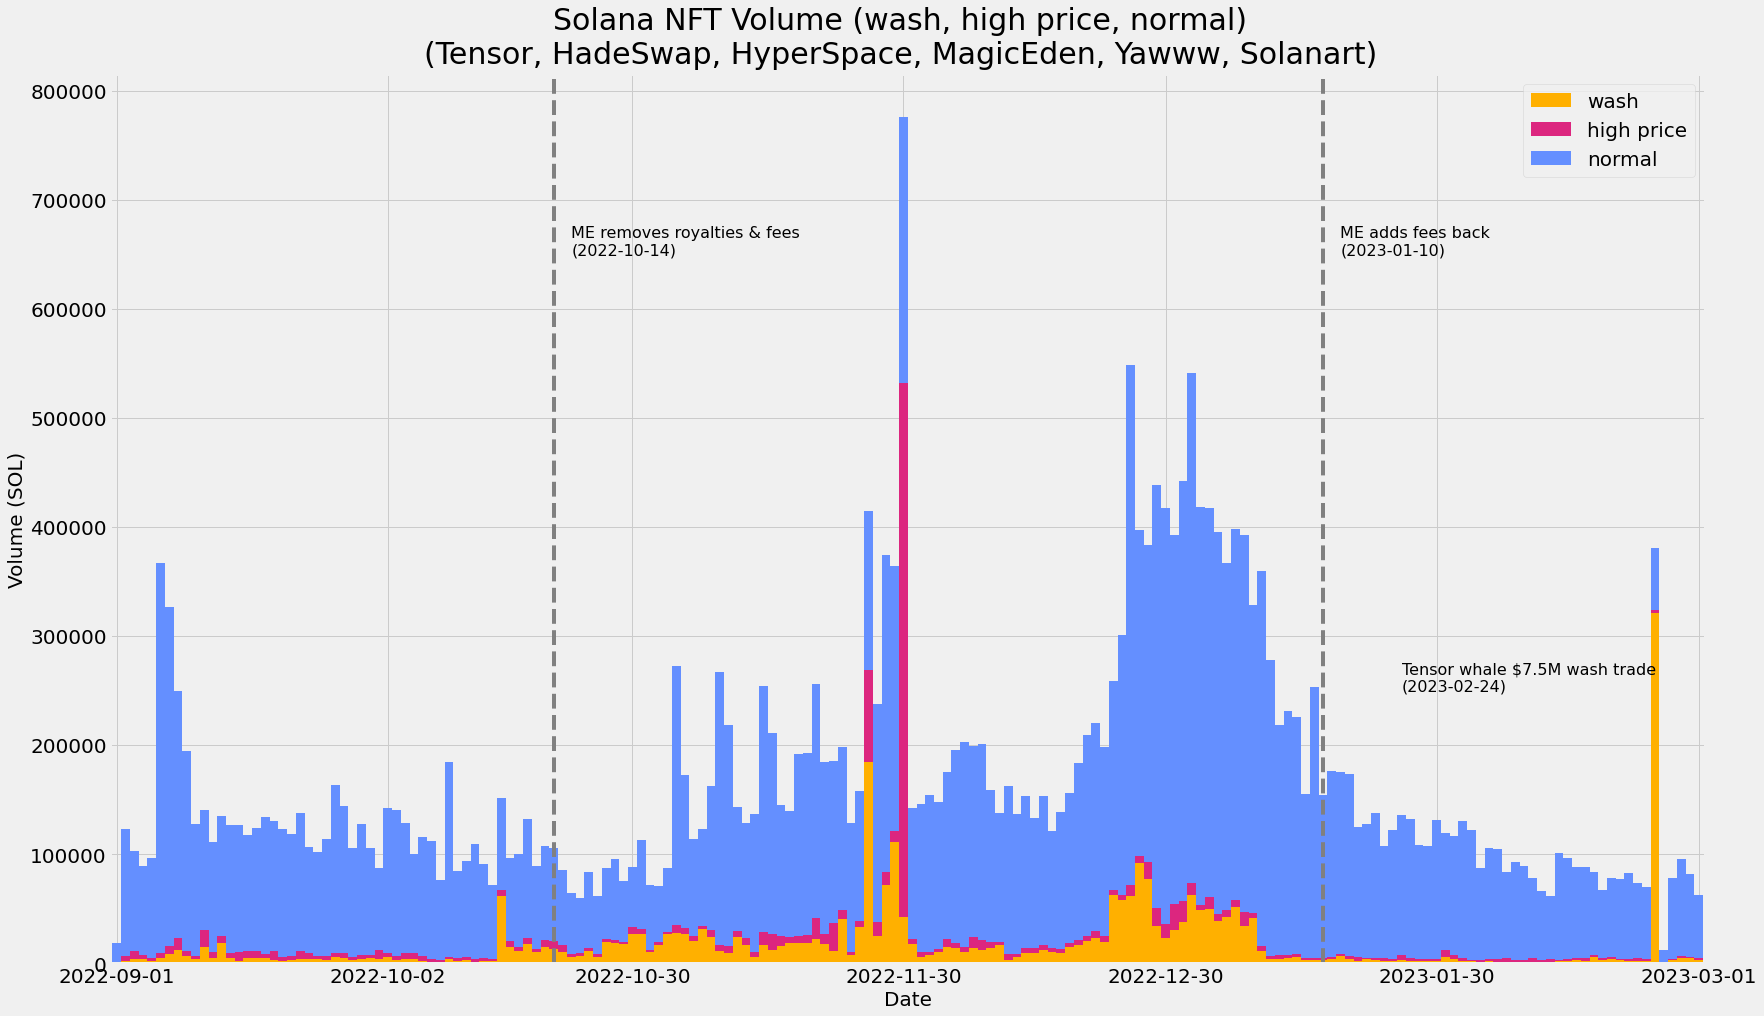

In [29]:
fig, ax = plt.subplots(
    figsize=(25, 15),
)
plt.grid()
plt.tight_layout(pad=6)
plot_source(df_all_out, None, ax=ax)
fig.suptitle('Solana NFT Volume (wash, high price, normal)\n(Tensor, HadeSwap, HyperSpace, MagicEden, Yawww, Solanart)',
             fontsize=30)

first = dt.date(2022,8,25)
date1 = (dt.date(2022,10,14) - first).days
ax.axvline(x=date1, linestyle='--', color='gray')
ax.text(date1 + 2, 650000, 'ME removes royalties & fees\n(2022-10-14)', fontsize=16)

date2 = (dt.date(2023,1,10) - first).days
ax.axvline(x=date2, linestyle='--', color='gray')
ax.text(date2 + 2, 650000, 'ME adds fees back\n(2023-01-10)', fontsize=16)

date3 = (dt.date(2023,2,24) - first).days
ax.axvline(x=date3, linestyle='--', color='gray')
ax.text(date3 -36, 250000, 'Tensor whale $7.5M wash trade\n(2023-02-24)', fontsize=16)

Text(147, 250000, 'Tensor whale $7.5M wash trade\n(2023-02-24)')

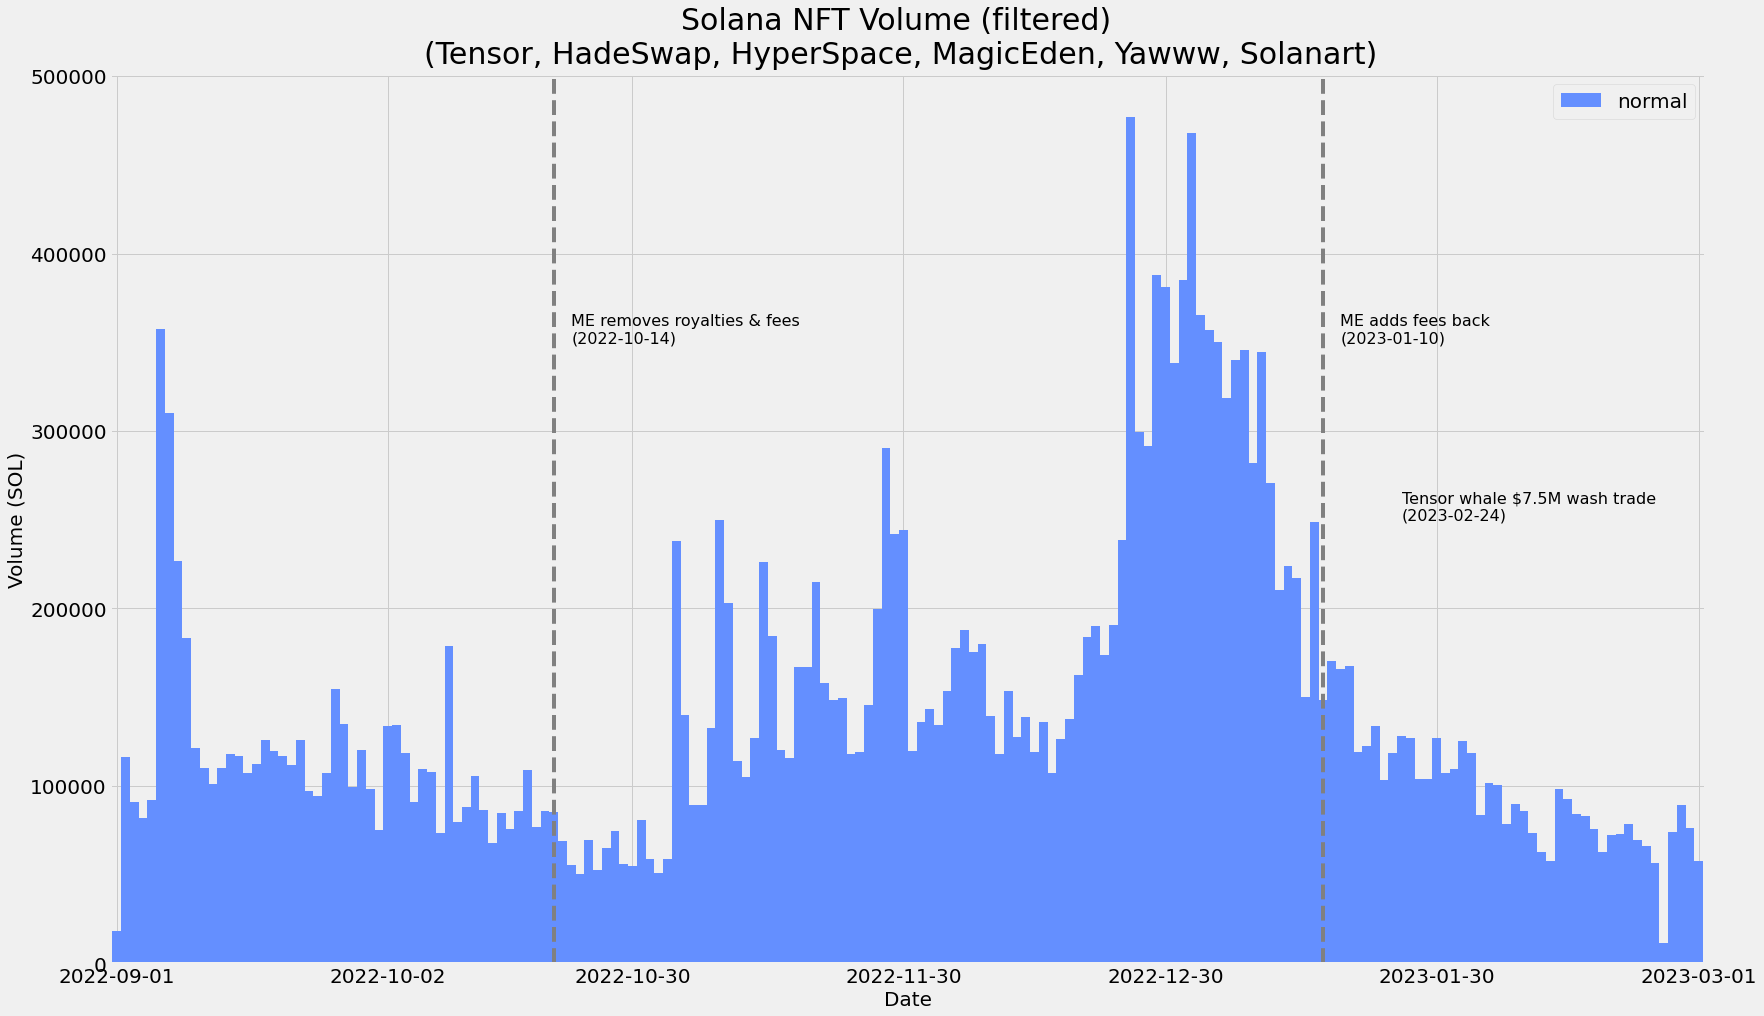

In [30]:
fig, ax = plt.subplots(
    figsize=(25, 15),
)
plt.grid()
plt.tight_layout(pad=6)
plot_source(df_all_out, None, ax=ax, only_normal=True)
fig.suptitle('Solana NFT Volume (filtered) \n(Tensor, HadeSwap, HyperSpace, MagicEden, Yawww, Solanart)',
             fontsize=30)

first = dt.date(2022,8,25)
date1 = (dt.date(2022,10,14) - first).days
ax.axvline(x=date1, linestyle='--', color='gray')
ax.text(date1 + 2, 350000, 'ME removes royalties & fees\n(2022-10-14)', fontsize=16)

date2 = (dt.date(2023,1,10) - first).days
ax.axvline(x=date2, linestyle='--', color='gray')
ax.text(date2 + 2, 350000, 'ME adds fees back\n(2023-01-10)', fontsize=16)

date3 = (dt.date(2023,2,24) - first).days
ax.axvline(x=date3, linestyle='--', color='gray')
ax.text(date3 -36, 250000, 'Tensor whale $7.5M wash trade\n(2023-02-24)', fontsize=16)

## By marketplace

Text(0.5, 54.09999999999995, 'Date')

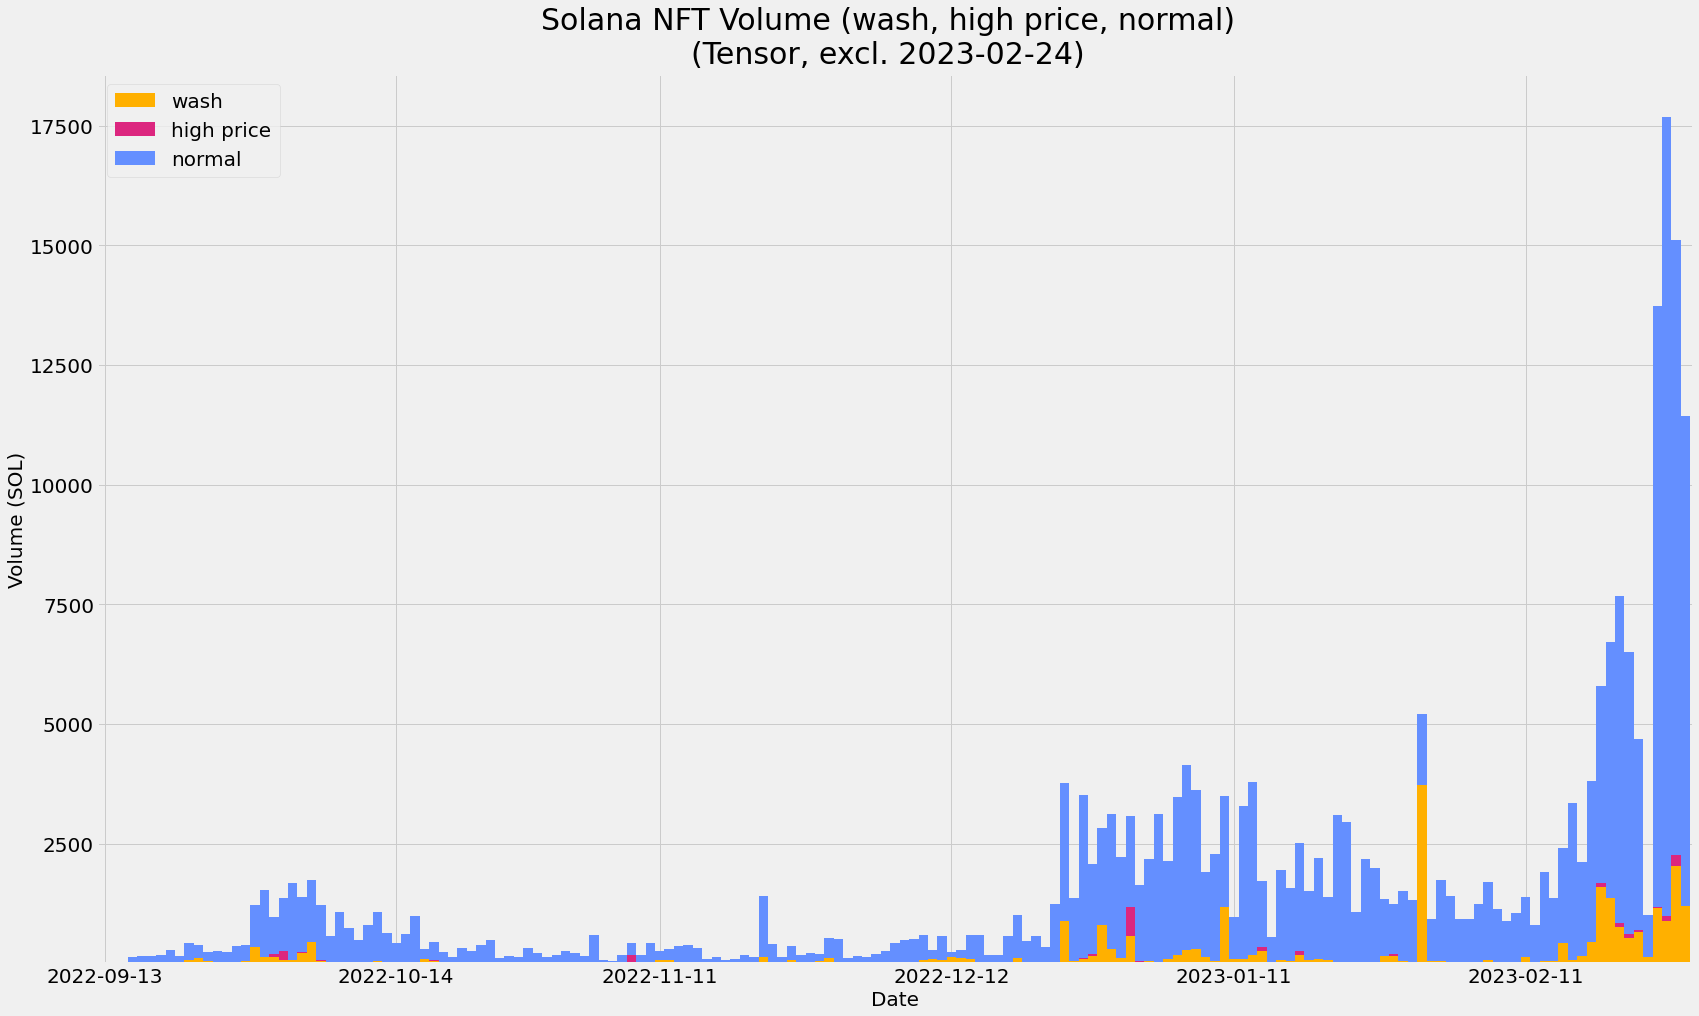

In [31]:
fig, ax = plt.subplots(figsize=(25, 15))
plt.grid()
plt.tight_layout(pad=6)

plot_source(df_all_out[df_all_out.date.dt.date != dt.date(2023,2,24)], 'TENSORSWAP', ax=ax)
fig.suptitle('Solana NFT Volume (wash, high price, normal)\n(Tensor, excl. 2023-02-24)', fontsize=30)
ax.set_ylabel('Volume (SOL)', fontsize=20)
ax.set_xlabel('Date', fontsize=20)

Text(0.5, 54.09999999999995, 'Date')

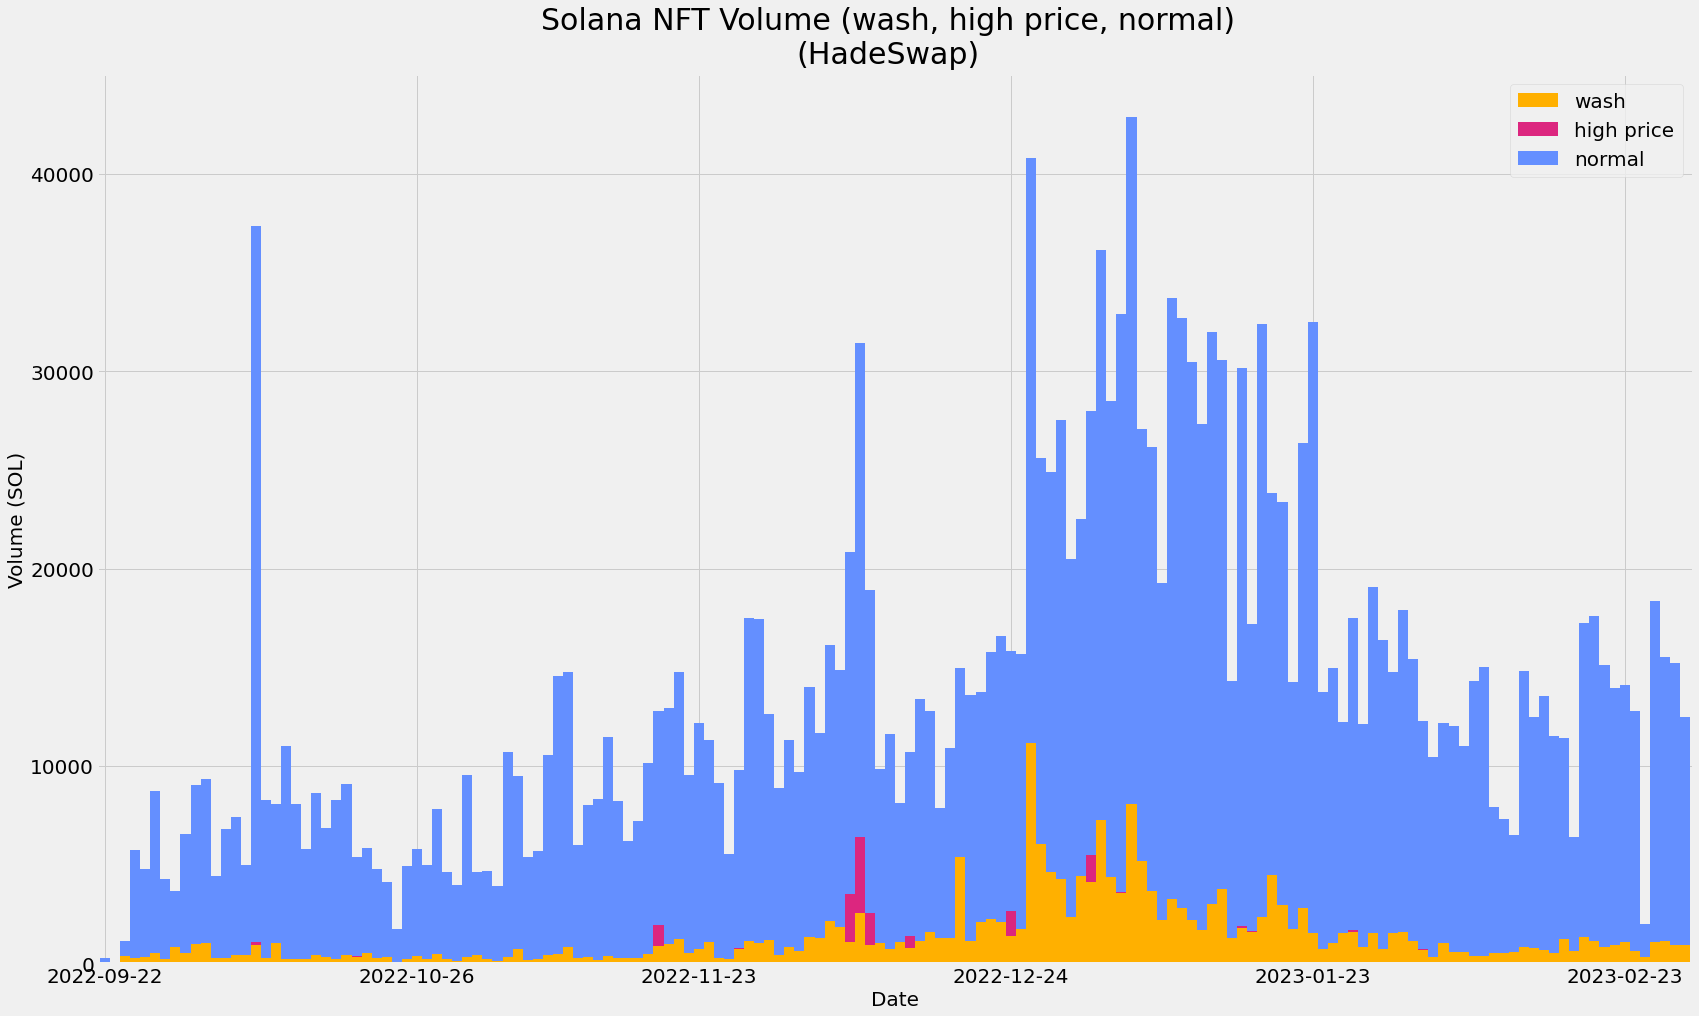

In [32]:
fig, ax = plt.subplots(figsize=(25, 15))
plt.grid()
plt.tight_layout(pad=6)

plot_source(df_all_out, 'HADESWAP', ax=ax)
fig.suptitle('Solana NFT Volume (wash, high price, normal)\n(HadeSwap)', fontsize=30)
ax.set_ylabel('Volume (SOL)', fontsize=20)
ax.set_xlabel('Date', fontsize=20)

Text(0.5, 54.09999999999995, 'Date')

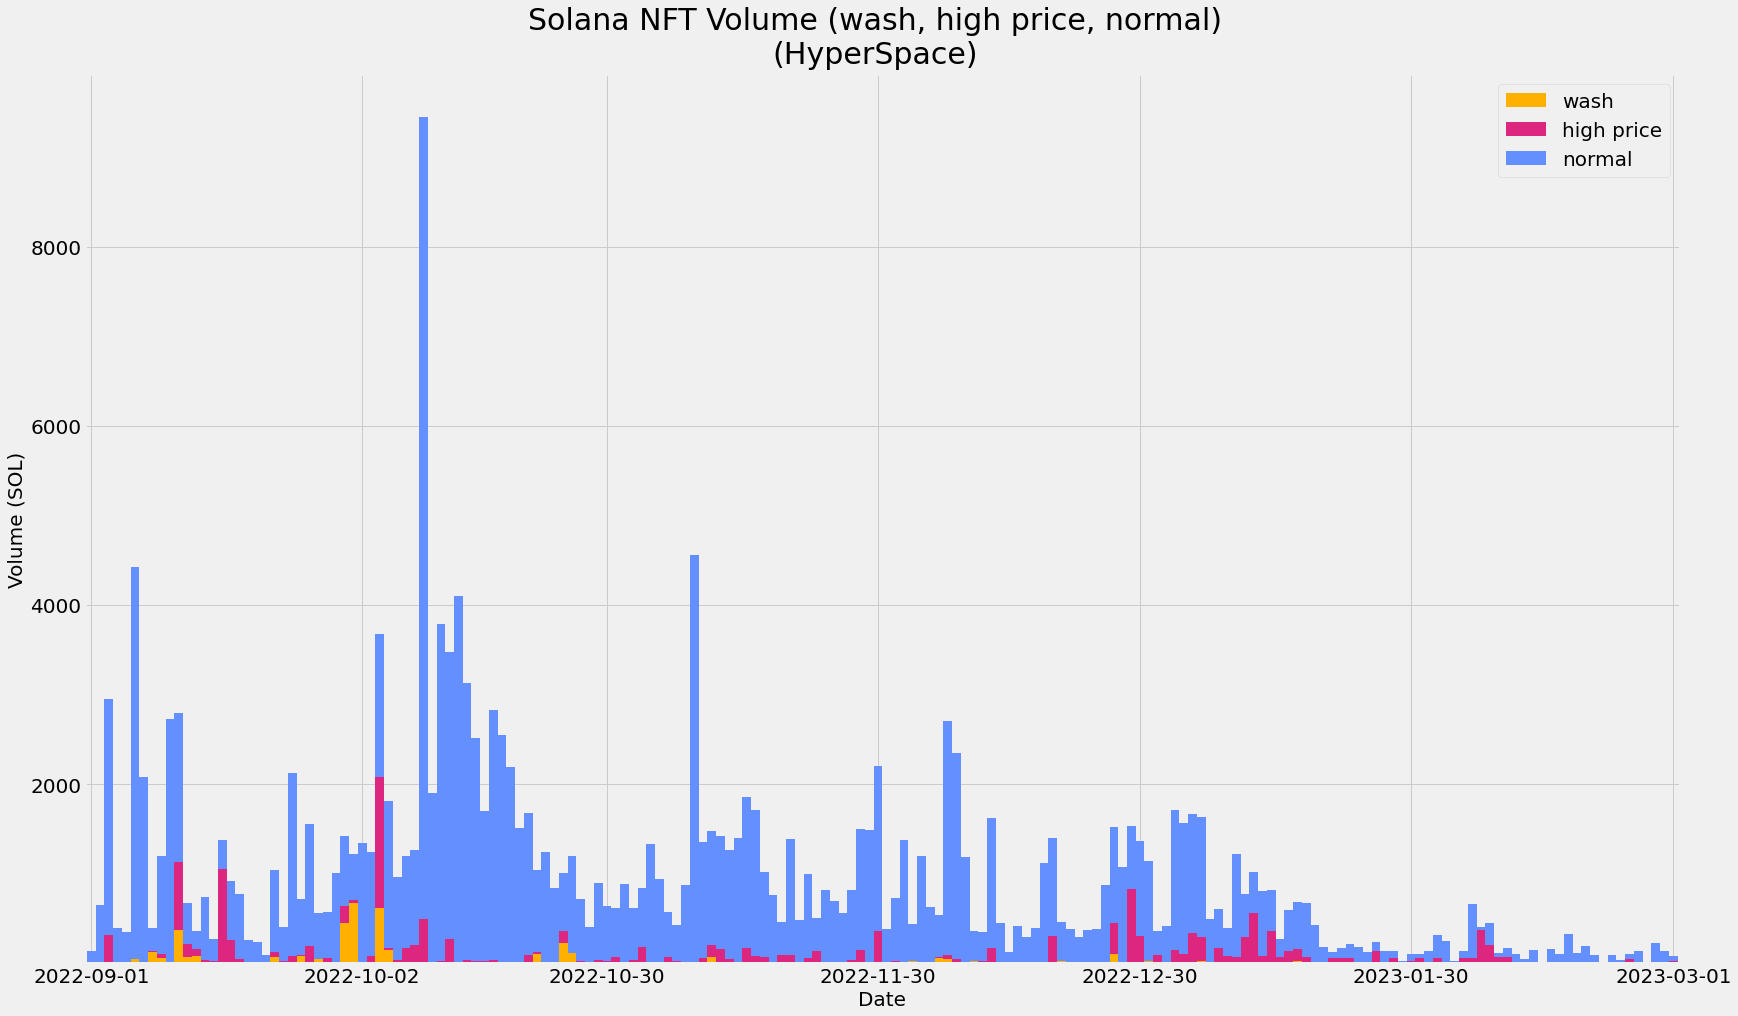

In [33]:
fig, ax = plt.subplots(figsize=(25, 15))
plt.grid()
plt.tight_layout(pad=6)

plot_source(df_all_out, 'HYPERSPACE', ax=ax)
fig.suptitle('Solana NFT Volume (wash, high price, normal)\n(HyperSpace)', fontsize=30)
ax.set_ylabel('Volume (SOL)', fontsize=20)
ax.set_xlabel('Date', fontsize=20)

Text(0.5, 54.09999999999995, 'Date')

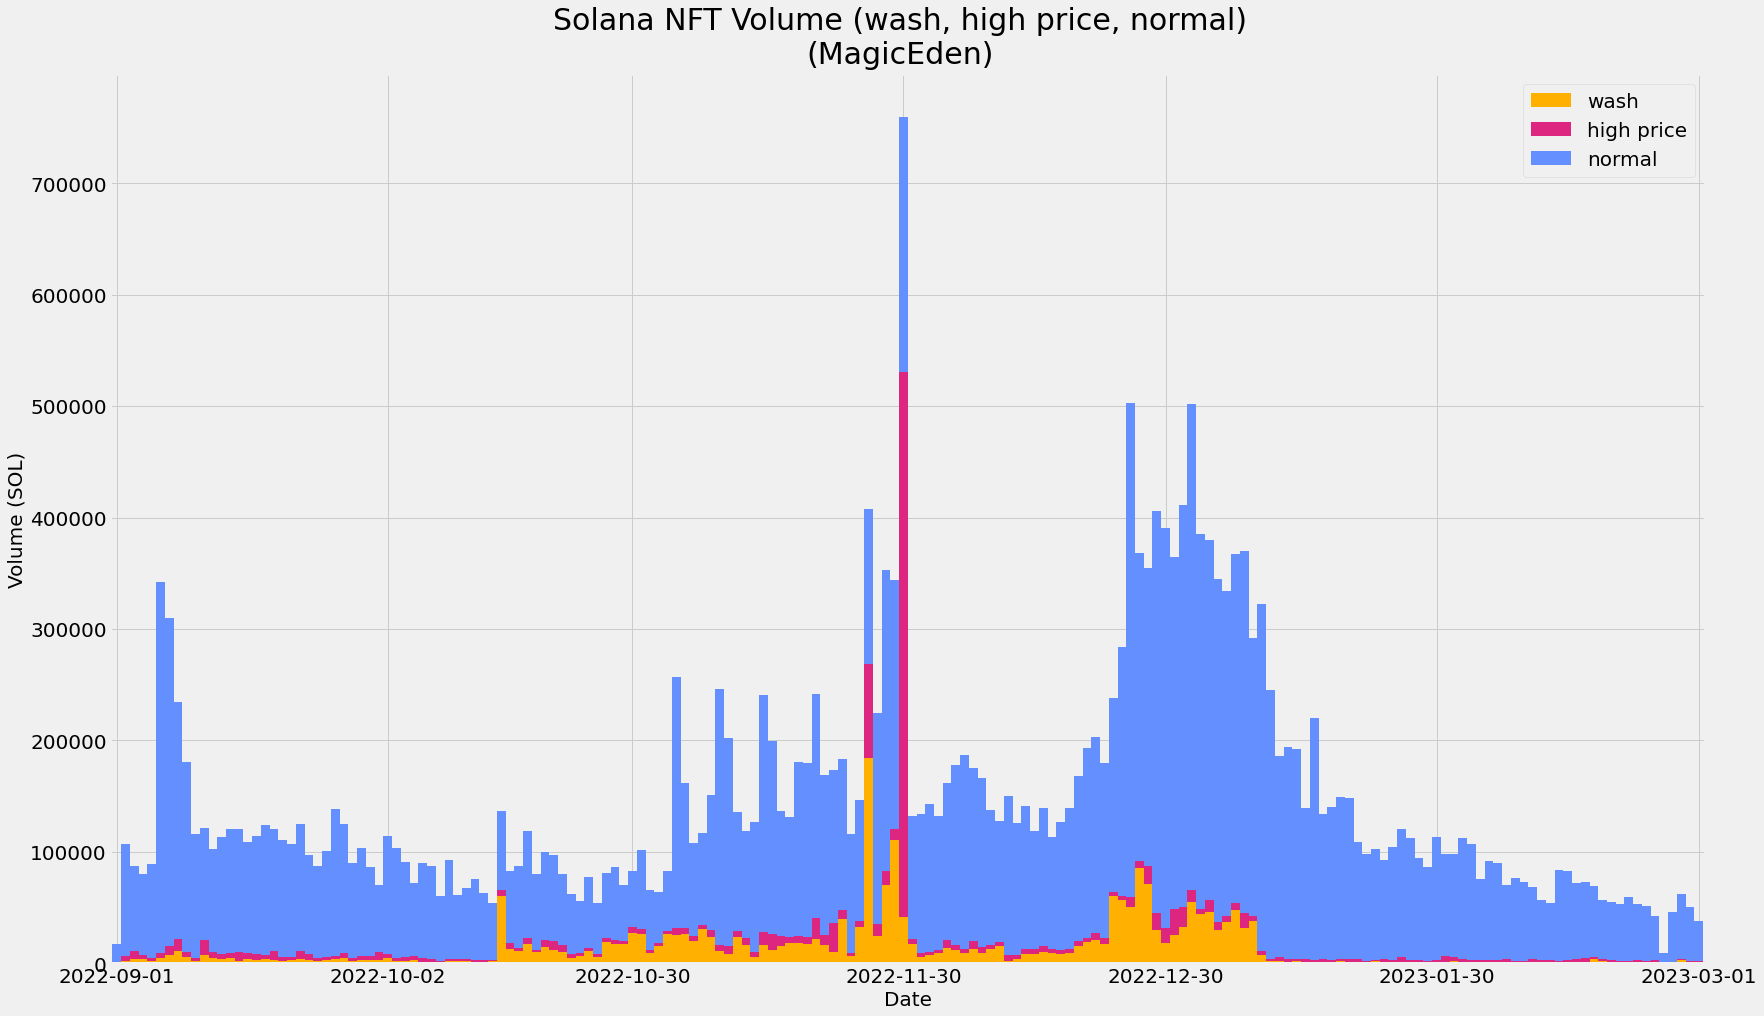

In [35]:
fig, ax = plt.subplots(figsize=(25, 15))
plt.grid()
plt.tight_layout(pad=6)

plot_source(df_all_out, 'MAGICEDEN_V2', ax=ax)
fig.suptitle('Solana NFT Volume (wash, high price, normal)\n(MagicEden)', fontsize=30)
ax.set_ylabel('Volume (SOL)', fontsize=20)
ax.set_xlabel('Date', fontsize=20)

Text(0.5, 54.09999999999995, 'Date')

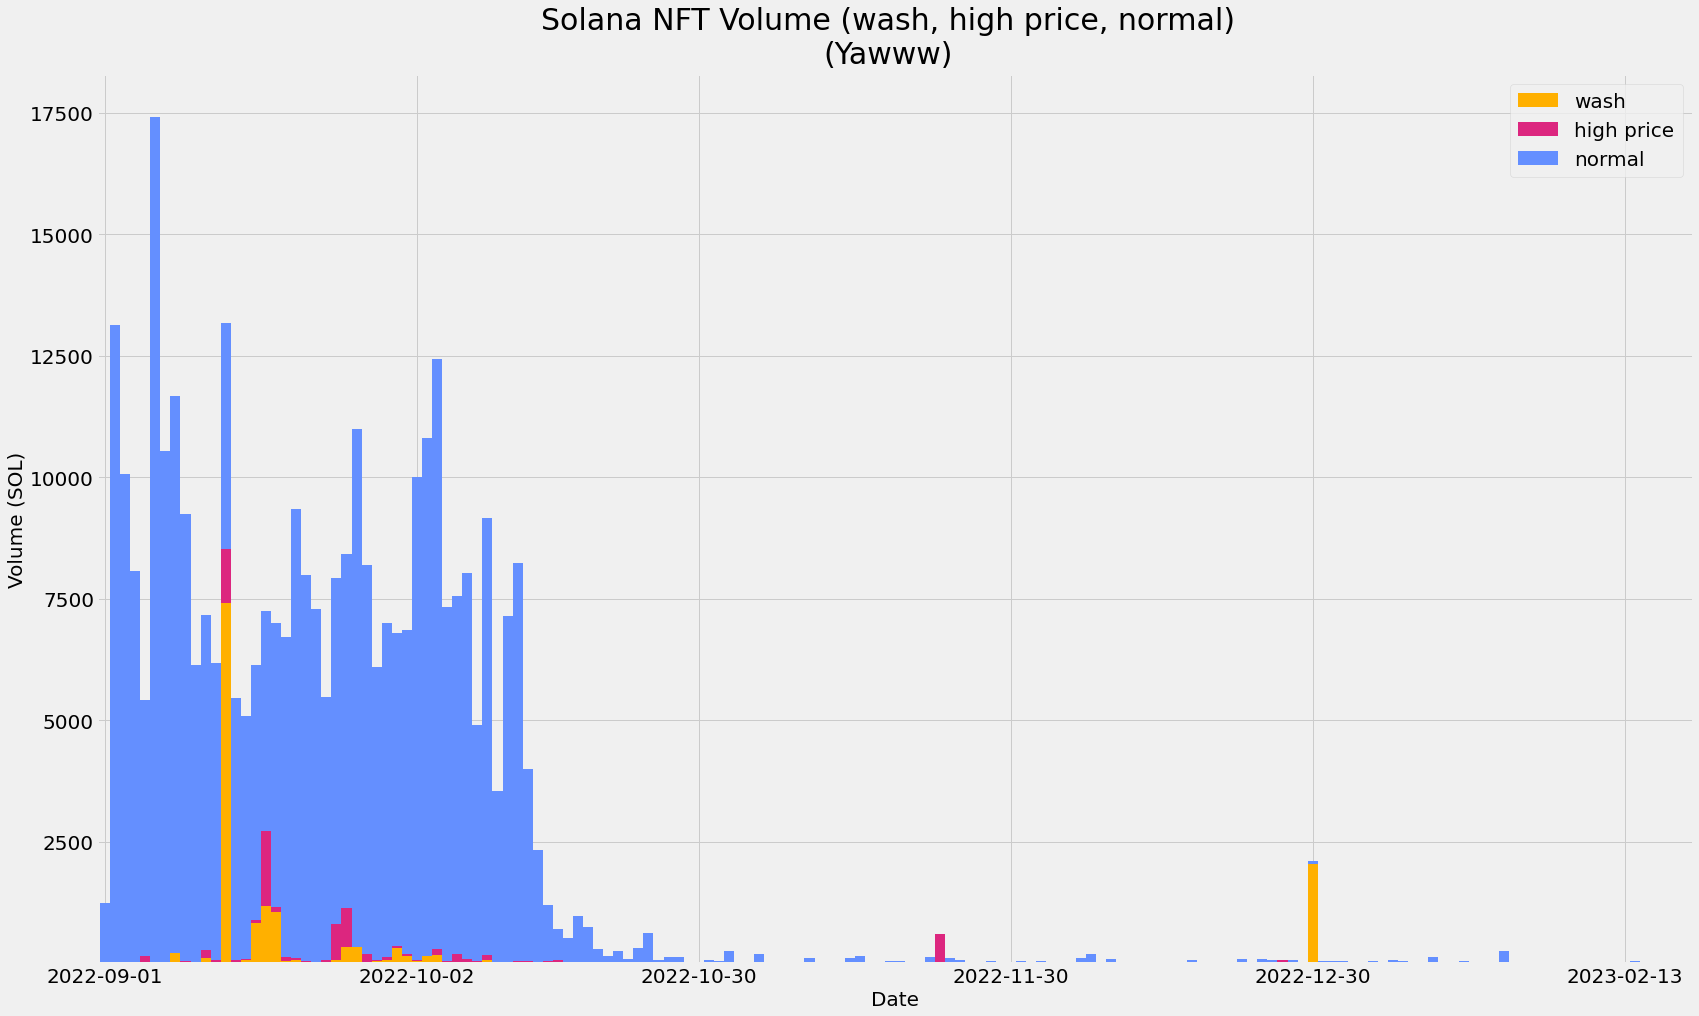

In [36]:
fig, ax = plt.subplots(figsize=(25, 15))
plt.grid()
plt.tight_layout(pad=6)

plot_source(df_all_out, 'YAWWW', ax=ax)
fig.suptitle('Solana NFT Volume (wash, high price, normal)\n(Yawww)', fontsize=30)
ax.set_ylabel('Volume (SOL)', fontsize=20)
ax.set_xlabel('Date', fontsize=20)

Text(0.5, 54.09999999999995, 'Date')

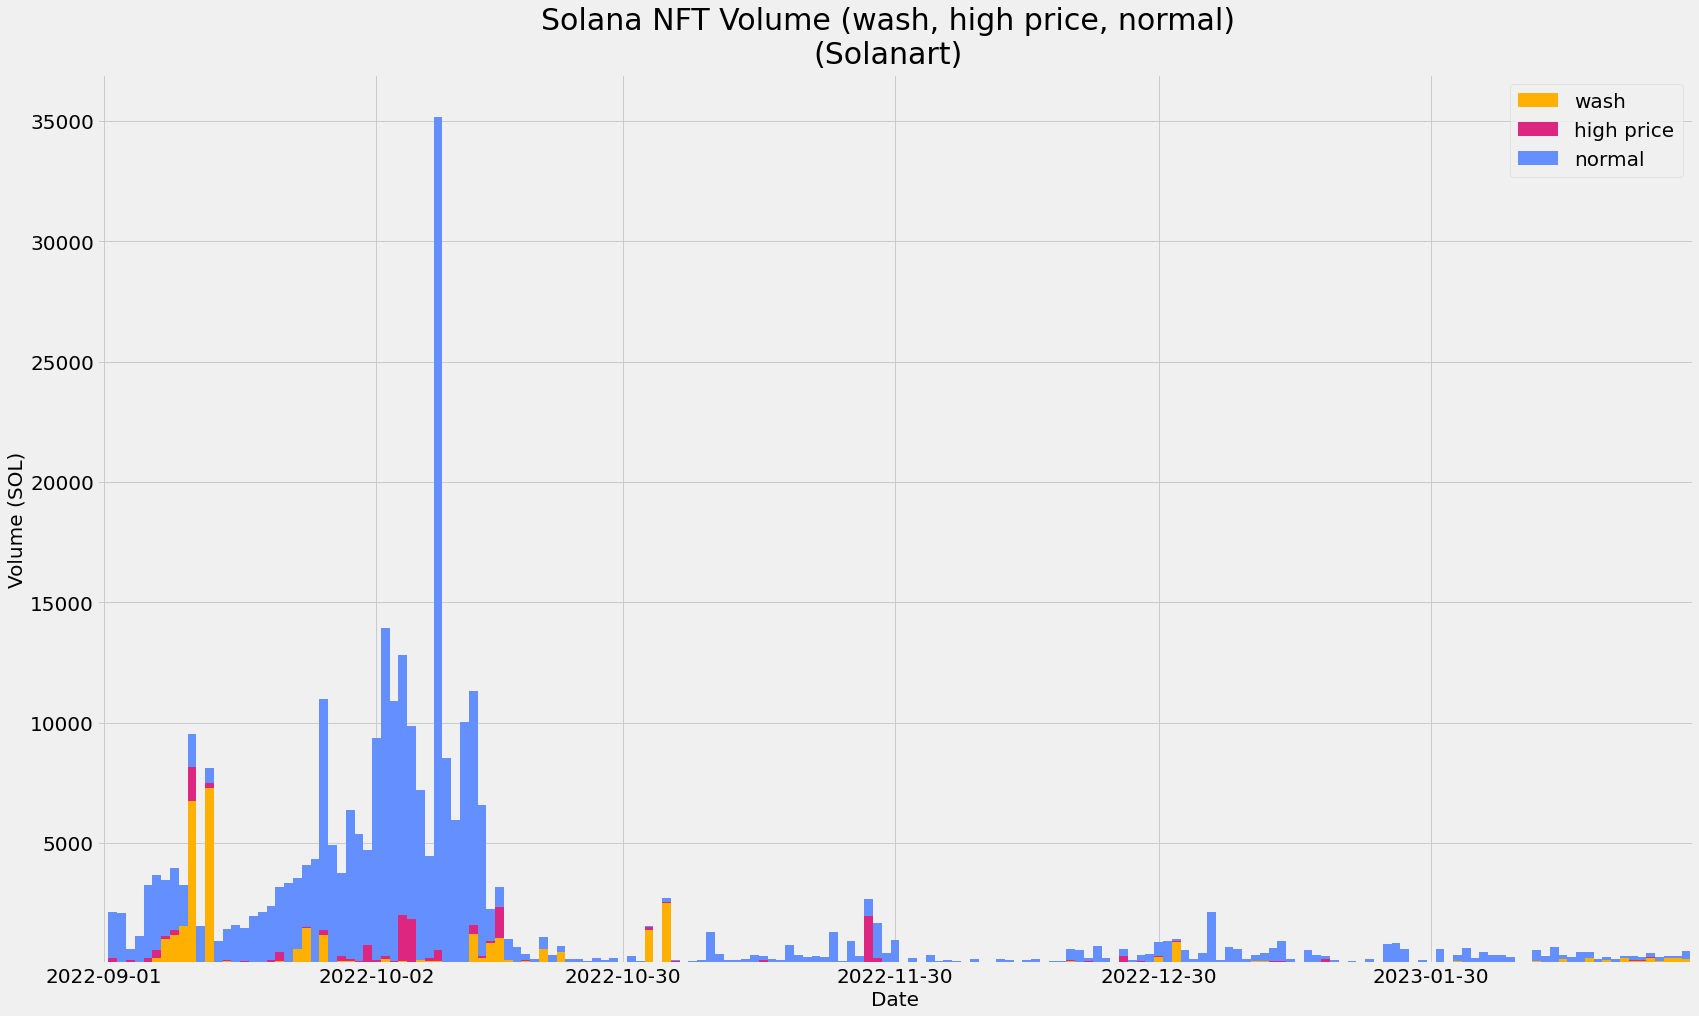

In [37]:
fig, ax = plt.subplots(figsize=(25, 15))
plt.grid()
plt.tight_layout(pad=6)

plot_source(df_all_out, 'SOLANART', ax=ax)
fig.suptitle('Solana NFT Volume (wash, high price, normal)\n(Solanart)', fontsize=30)
ax.set_ylabel('Volume (SOL)', fontsize=20)
ax.set_xlabel('Date', fontsize=20)

In [38]:
def group_by_col(df_out, colName: str):
    df_group_totals = df_out.groupby(colName).grossAmount.sum().sort_values(ascending=False)
    df_group_wash = df_out[df_out['wash']].groupby(colName).grossAmount.sum().sort_values(ascending=False)
    df_group_exclude = df_out[df_out['highprice'] & ~df_out['wash']].groupby(colName).grossAmount.sum().sort_values(ascending=False)

    df_group_all = pd.concat([df_group_totals, df_group_wash, df_group_exclude], axis=1)
    df_group_all.columns = ['total', 'wash', 'high price']
    df_group_all = df_group_all.fillna(0)
    df_group_all['wash_hp_pct'] = (df_group_all['wash'] + df_group_all['high price']) / df_group_all['total']
    return df_group_all

## Collections

In [39]:
df_coll_all = group_by_col(df_all_out, 'slugDisplay')

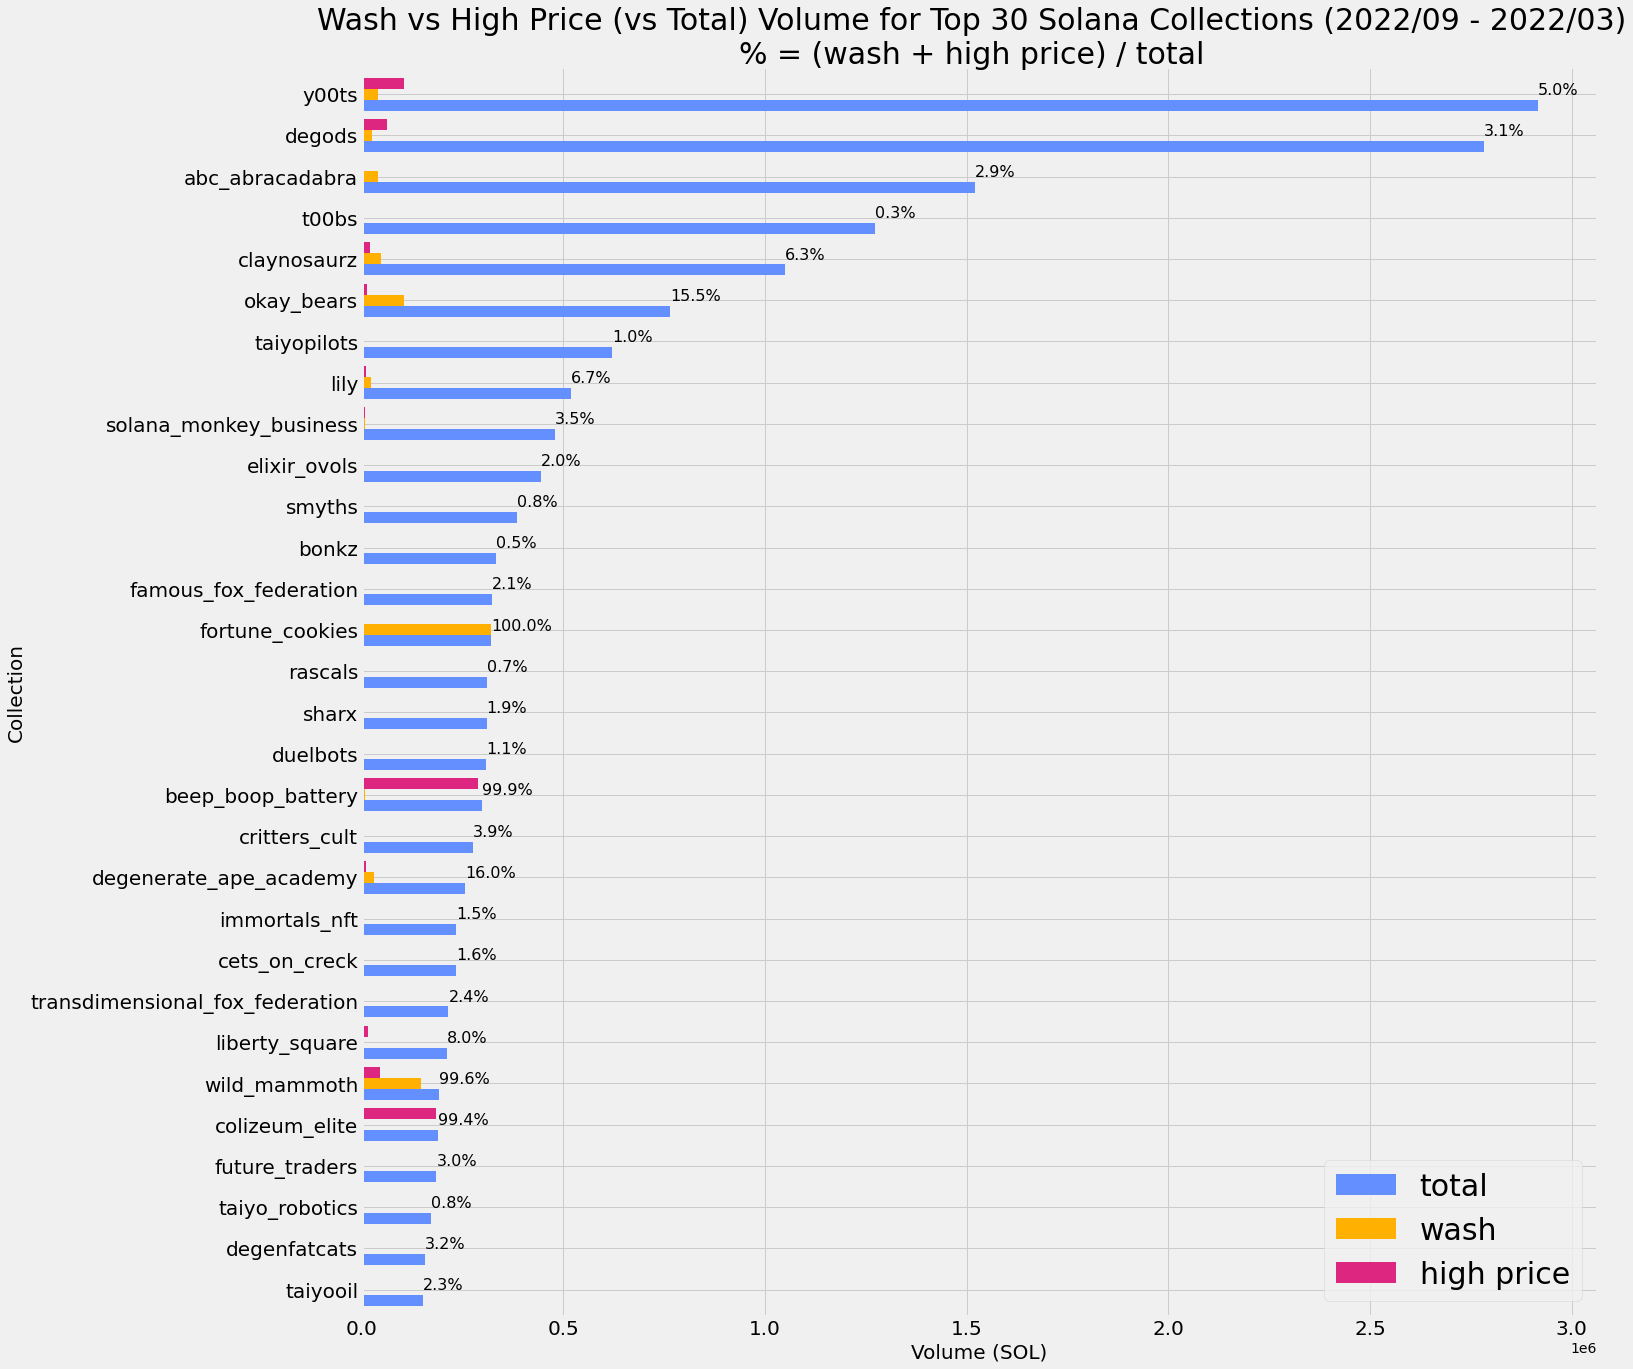

In [41]:
topn = 30
fig, ax = plt.subplots(figsize=(20, 20))
plt.tight_layout(pad=6)

df_temp = df_coll_all.head(n=topn).iloc[::-1]
df_temp[['total', 'wash', 'high price']].plot(kind='barh', ax=ax, fontsize=20,
                                             color=[NORMAL_COL, WASH_COL, HP_COL],
                                             width=0.8)
ax.set_ylabel('Collection', fontsize=20)
ax.set_xlabel('Volume (SOL)', fontsize=20)
ax.legend(fontsize=30)
fig.suptitle(f'Wash vs High Price (vs Total) Volume for Top {topn} Solana Collections (2022/09 - 2022/03)\n% = (wash + high price) / total', fontsize=30)

for idx, (_, row) in enumerate(df_temp.iterrows()):
    ax.text(row['total'], idx, s=f'{round(row["wash_hp_pct"] * 100, 1)}%', fontsize=16)

## Wallets

In [42]:
def group_by_wallet(df_out):
    df_buyer = group_by_col(df_out, 'buyerId')
    df_seller = group_by_col(df_out, 'sellerId')

    df_wallet_temp = df_buyer.merge(df_seller, how='outer', left_index=True, right_index=True).fillna(0)

    for col in df_buyer.columns:
        if col == 'wash_hp_pct':
            continue
        df_wallet_temp[col] = df_wallet_temp[col + '_x'] + df_wallet_temp[col + '_y']
    df_wallet_temp['wash_hp_pct'] = ((df_wallet_temp['wash'] + df_wallet_temp['high price']) / df_wallet_temp['total']).fillna(0.)
    df_wallet = df_wallet_temp[df_buyer.columns].sort_values('total', ascending=False)
    df_wallet['normal'] = df_wallet['total'] - df_wallet['wash'] - df_wallet['high price']
    return df_wallet

In [43]:
df_wallet_all = group_by_wallet(df_all_out)

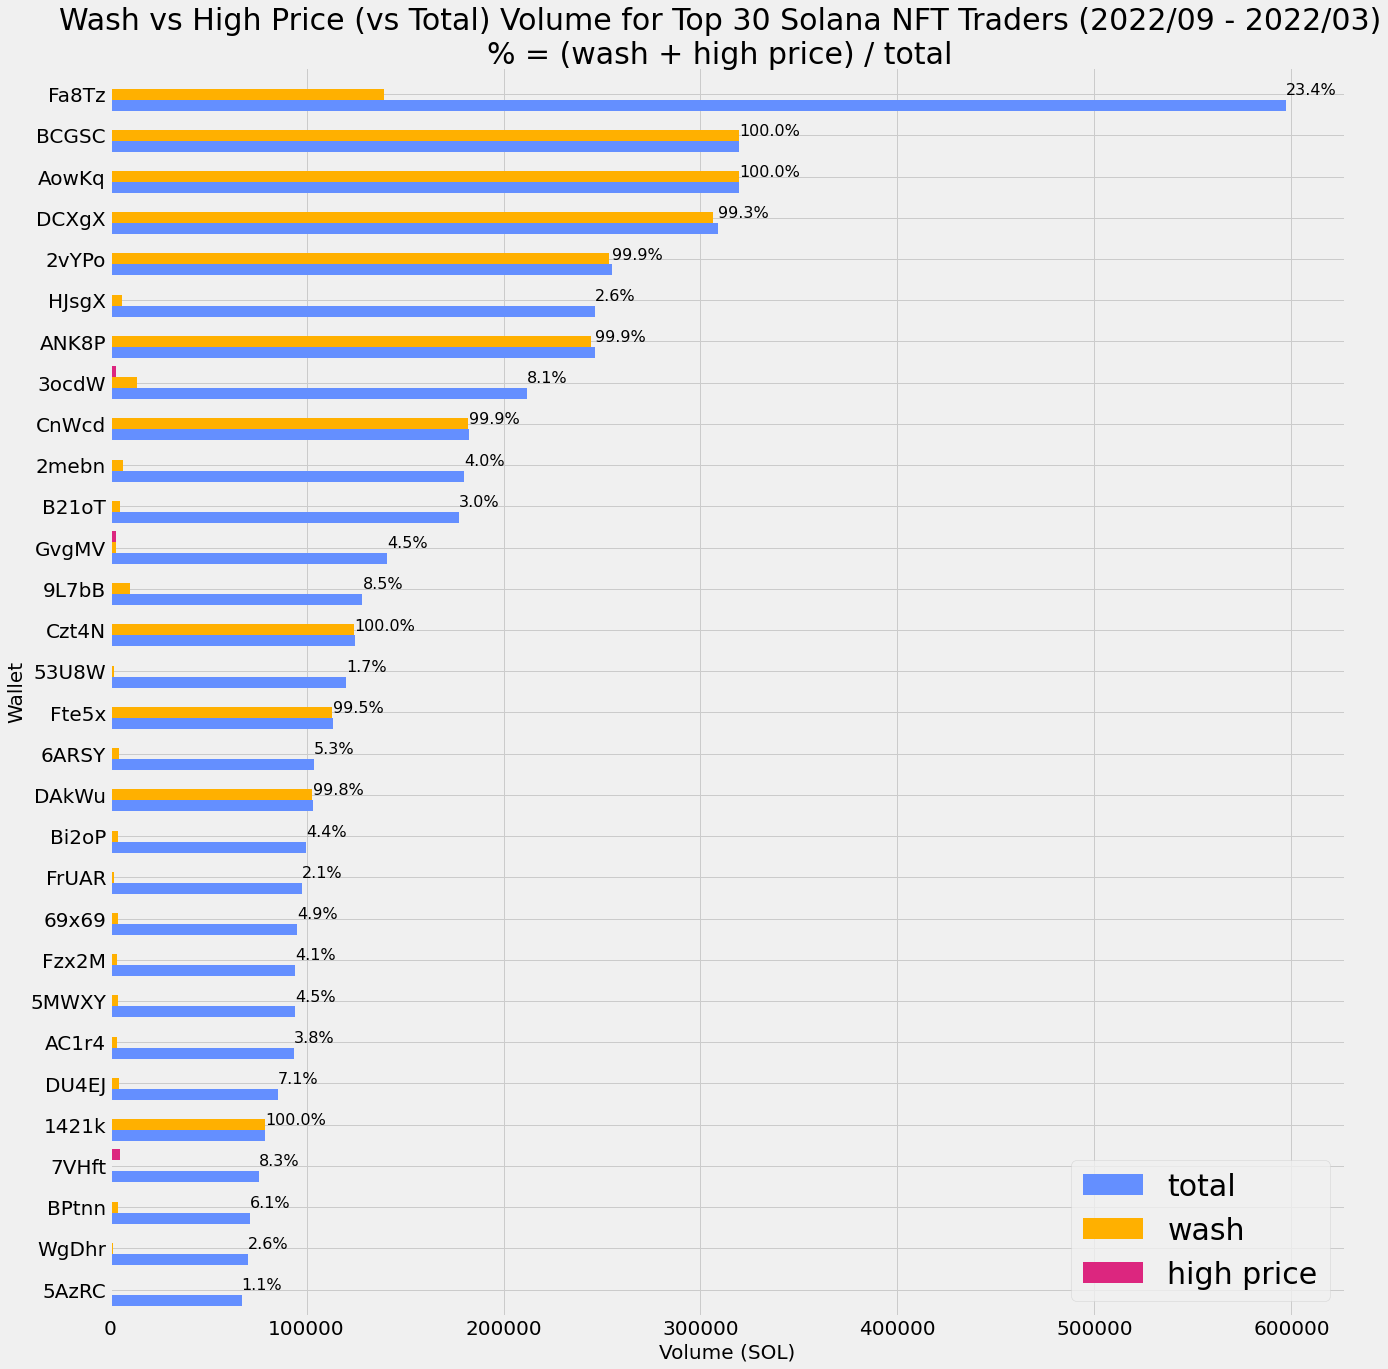

In [45]:
topn = 30
fig, ax = plt.subplots(figsize=(20, 20))
plt.tight_layout(pad=6)

df_temp = df_wallet_all.head(n=topn).iloc[::-1]
df_temp.index = df_temp.index.str.slice(0,5)
df_temp[['total', 'wash', 'high price']].plot(kind='barh', ax=ax, fontsize=20,
                                             color=[NORMAL_COL, WASH_COL, HP_COL],
                                             width=0.8)
ax.set_ylabel('Wallet', fontsize=20)
ax.set_xlabel('Volume (SOL)', fontsize=20)
ax.legend(fontsize=30)
fig.suptitle(f'Wash vs High Price (vs Total) Volume for Top {topn} Solana NFT Traders (2022/09 - 2022/03)\n% = (wash + high price) / total', fontsize=30)

for idx, (_, row) in enumerate(df_temp.iterrows()):
    ax.text(row['total'], idx, s=f'{round(row["wash_hp_pct"] * 100, 1)}%', fontsize=16)

### Wallet volume dist

In [46]:
df_normal_all = df_wallet_all['normal'].sort_values(ascending=False)

In [47]:
df_cumpct = df_normal_all.reset_index(drop=True)
df_cumpct = (df_normal_all.cumsum() / df_normal_all.sum() * 100)

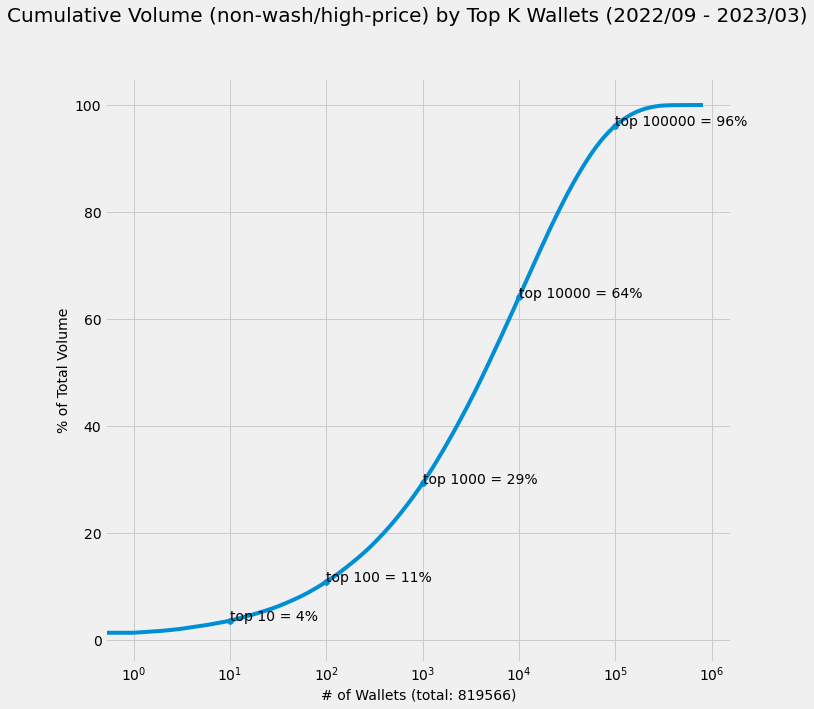

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
df_cumpct.plot()
ax.set_xscale('log')

fig.suptitle('Cumulative Volume (non-wash/high-price) by Top K Wallets (2022/09 - 2023/03)',
            fontsize=20)
ax.set_ylabel('% of Total Volume', fontsize=14)
ax.set_xlabel('# of Wallets (total: 819566)', fontsize=14)

topk =[10, 100, 1000, 10000, 100000]
topk_pct = [df_cumpct.iloc[k] for k in topk]
ax.scatter(x=topk, y=topk_pct)

for x, y in zip(topk, topk_pct):
    ax.annotate(f'top {x} = {round(y)}%', (x, y), fontsize=14)

In [49]:
df_wash_highprice_out = df_all_out[df_all_out['wash'] | df_all_out['highprice']]
df_suspect_buyers = df_wash_highprice_out.groupby('buyerId')['grossAmount'].sum().sort_values(ascending=False)
df_suspect_sellers = df_wash_highprice_out.groupby('sellerId')['grossAmount'].sum().sort_values(ascending=False)
df_suspect_wallets = pd.concat([df_suspect_buyers, df_suspect_sellers], axis=1).sum(axis=1).sort_values(ascending=False)

### Total volume (6 mos)

In [50]:
df_all_out['grossAmount'].sum()

30892766.973033585

### Wash %

In [51]:
df_wash_highprice_out['grossAmount'].sum() / df_all_out['grossAmount'].sum()

0.1458205359040615

In [53]:
df_suspect_wallets.head(n=20)

BCGSCD3Jw6SEzkBQH3vKGNSoPcfMZe3mS1m5AN8zRvzX    319608.500000
AowKqCD2zp8Lq5ouXrVCqNgEwcwwwRSXguRAAtLS4HCC    319608.500000
DCXgXgEdtYdXNQa7bUzUyLADaG3bU6WUJ5cCBY9NPzao    306923.859125
2vYPosCt8Hps1TFHXUkT2Ea4EyRtETzQZN3bbvmV47zm    255049.608836
ANK8PUib8hhAy5ifoM3PC5fybdMqscoaskUBPvf2gVR6    246124.048655
CnWcdawb21qUjASnN8Zr6cik9eRYtKtRCixQG3JqdEe6    182413.004300
Fa8TzVCkeQd7ZMcGNZEvC3kvSKtxMymdv1gCVZoPexuW    139476.921857
Czt4NSeiinkfTpa3E3Hdk2skvx21Bnr79a8SqAJnjWLh    124321.075976
Fte5xtVTwAjv7h961d7G1oqNint5SPKETY87eVjuMc84    113112.803297
DAkWuntS4Svn81ySqchMvtK6oyLogD3qo9Kx5qWopZiC    102982.029980
1421khSfqo4Qd3norRLmSKVm8ev3W2rHmeJFM5XiyPCH     78846.509989
GeA2NVKWeMLbKMzVfgCvT32TMWK1MyfwPcV6howgVMqg     65260.330319
2GExDZb7ohyNsz2GN9uHijVTfjsv58kdSqbc4mQJy2f2     61197.648328
7W2TTRVkjp48xS2Upn4UvhyT21AWtu6NcWPunr72yM6S     58997.361281
2ML2sdwKiEMqrFRfuHhQ6haVSQCE8J2Y5Gf1pdrgBMvj     55408.792238
Fof6GTXEyUyKjVtPhSCyUPmwg8BH6eUm6PgbpUo46zXP     48891.137635
6ANiQDUU

# Write results pickle

In [54]:
df_all_out.to_pickle('../data/20230301_df_all_out.pkl')